In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from src.models.classification.evaluate_models import ClassificationAnalysis
from src.models.classification.train_models import ClassificationTraining
from src.visualization.styles.formatting import errorbar_kwargs

In [2]:
samples_per_composition = 30

training = ClassificationTraining(samples_per_composition=samples_per_composition)
analysis = ClassificationAnalysis(samples_per_composition=samples_per_composition)

results = training.load_training_models()
indices = analysis.load_performance_indices()

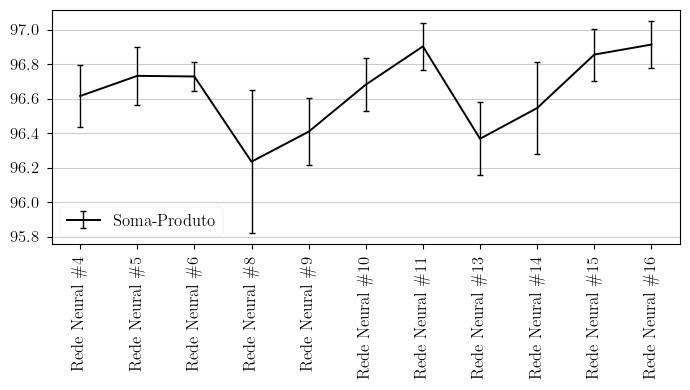

In [3]:
name = "sp_index"
# models = [i for i in range(19, 34)]
models = [21, 22, 23, 25, 26, 27, 28, 30, 31, 32, 33]

outputs = [output for i, output in enumerate(results["outputs"]) if i in models]
labels = [hp["model_name"].replace("#", "\#") for hp in outputs]
x = np.array([i + 1 for i in np.arange(len(outputs))])

f, ax = plt.subplots(figsize=(7, 4))

y = indices[name][:, models].mean(axis=0) * 100
y_err = (indices[name][:, models].std(axis=0) / np.sqrt(10 - 1)) * 100
ax.errorbar(x, y, y_err, label="Soma-Produto", **errorbar_kwargs)
ax.yaxis.grid()
ax.set_xticks(x, labels, rotation=90, ha="center")
ax.legend(loc="lower left")

f.tight_layout()
f.savefig(os.path.join("data", "images", f"{name}_errorbar_plot_alt.png"), dpi=600)

In [4]:
# Rede Neural #11 - Id: 28
# Rede Neural #15 - Id: 32
# Rede Neural #16 - Id: 33
#
# Wilcoxon test
# The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples
# come from the same distribution. In particular, it tests whether the distribution of the
# differences x - y is symmetric about zero. It is a non-parametric version of the paired
# T-test.
#
#   - alternative='two-sided': the distribution underlying d is not symmetric about zero.

from scipy import stats


def wilcoxon_test(sample1: np.ndarray, sample2: np.ndarray):
    d = np.around(sample1 - sample2, decimals=3)
    return stats.wilcoxon(d, alternative="two-sided")


print(wilcoxon_test(indices["sp_index"][:, 28], indices["sp_index"][:, 33]))
print(wilcoxon_test(indices["sp_index"][:, 32], indices["sp_index"][:, 33]))

WilcoxonResult(statistic=16.0, pvalue=0.43803541595496487)
WilcoxonResult(statistic=8.5, pvalue=0.6732899796599957)


In [5]:
indices["sp_index"][:, :].shape

(10, 36)

## Confusion Matrix

In [27]:
outputs

[{'folds': [{'fold': 1,
    'history':      categorical_accuracy      loss  val_categorical_accuracy  val_loss  \
    0                0.441441  1.006179                  0.757009  0.857746   
    1                0.824324  0.774892                  0.887850  0.649053   
    2                0.871622  0.585514                  0.901869  0.476198   
    3                0.887387  0.448087                  0.908879  0.361389   
    4                0.873874  0.363815                  0.920561  0.299568   
    ..                    ...       ...                       ...       ...   
    495              0.997748  0.024446                  0.962617  0.065337   
    496              0.997748  0.024491                  0.962617  0.065337   
    497              0.997748  0.024428                  0.962617  0.065337   
    498              0.997748  0.024277                  0.962617  0.065337   
    499              0.997748  0.024123                  0.962617  0.065337   
    
         lea

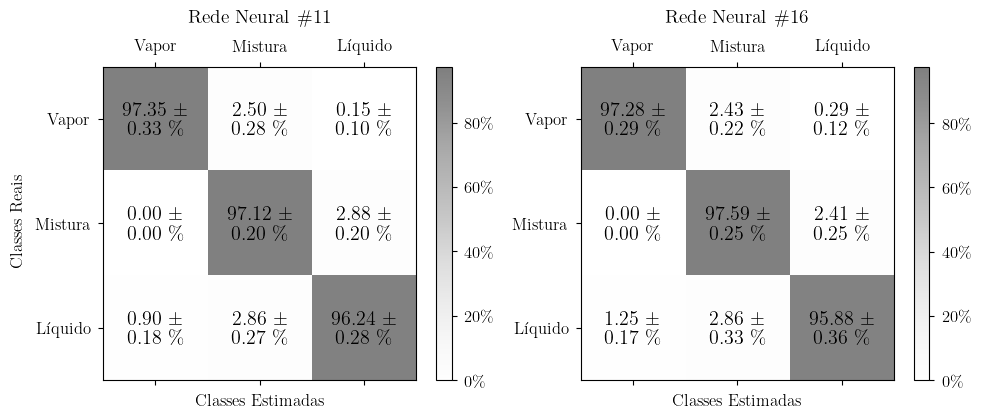

In [48]:
from matplotlib import ticker

models = [28, 33]
outputs = [output for i, output in enumerate(results["outputs"]) if i in models]
model_names = [res["model_name"].replace("#", "\#") for res in outputs]

f, axs = plt.subplots(1, len(models), figsize=(5 * len(models), 5))
for i, (model_info, ax) in enumerate(zip(results["outputs"], axs)):
    model_type = model_info["model_type"]
    model_id = model_info["model_id"]

    cm = indices["confusion_matrix"][:, models[i], :, :].astype("int16")

    cm = cm / np.sum(cm, axis=2)[:, :, None]
    cm_mean = np.mean(cm, axis=0)
    cm_std = np.std(cm, axis=0) / np.sqrt(10 - 1)

    ms = ax.matshow(cm_mean, alpha=0.5, cmap="Greys")
    for ii in range(cm_mean.shape[0]):
        for jj in range(cm_mean.shape[1]):
            text = f"{cm_mean[ii, jj] * 100:1.2f} \\textpm \n {cm_std[ii, jj] * 100:1.2f} \%"
            ax.text(x=jj, y=ii, s=text, va="center", ha="center", size="x-large")

    cbar = ax.figure.colorbar(ms, ax=ax, shrink=0.675, format=ticker.PercentFormatter(xmax=1))
    ax.set_xlabel("Classes Estimadas")
    # ax.set_ylabel("Classes Reais")
    ax.set_title(model_names[i])

    # 0: gas, 1: mix, 2: oil
    ax.set_xticks([0, 1, 2], ["Vapor", "Mistura", "Líquido"])
    ax.set_yticks([0, 1, 2], ["Vapor", "Mistura", "Líquido"])
    ax.grid(False)

f.supylabel("Classes Reais")
f.tight_layout()

plt.savefig(os.path.join("data", "images", "comparing_confusion_matrices.png"), dpi=600)
plt.show()